In [1]:
import sys
from pathlib import Path
from collections import defaultdict

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Need to use ._base module in missingpy package because .base was renamed to ._base 
# cf  https://github.com/epsilon-machine/missingpy/issues/27 
# import sklearn.neighbors._base
# sys.modules['sklearn.neighbors.base'] = sklearn.neighbors._base

# from missingpy import MissForest, KNNImputer

# explicitly require this experimental feature
from sklearn.experimental import enable_iterative_imputer  # noqa
# now you can import normally from sklearn.impute
from sklearn.impute import IterativeImputer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import ExtraTreesRegressor

### Results output files from MSDial are messy

Column names (starting from row 4, 0-indexed)

1. Alignment ID	
1. Average Rt(min)	
1. Average Mz	
1. Metabolite name	
1. Adduct type	
1. Post curation result	
1. Fill %	
1. MS/MS assigned	
1. Reference RT	
1. Reference m/z	
1. Formula	Ontology	
1. INCHIKEY	
1. SMILES	
1. Annotation tag (VS1.0)	
1. RT matched	
1. m/z matched	
1. MS/MS matched	
1. Comment	
1. Manually modified for quantification	
1. Manually modified for annotation	
1. Isotope tracking parent ID	
1. Isotope tracking weight number	
1. Total score	
1. RT similarity	
1. Dot product	
1. Reverse dot product	
1. Fragment presence %	
1. S/N average	
1. Spectrum reference file name	
1. MS1 isotopic spectrum
1. MS/MS spectrum

After: each column is one of the ~60 rawfile names, then it does a class summary with averages and standard deviations that I defined in the file metadata step in MSDial (I_R = impaired, random-fed.  D_F = diabetic, fasted)

In [2]:
neg_path = Path(r'..\data\raw\metabolomics\msdial_v2\neg_results\neg_results_with_gap_fill_compulsion.txt')
neg_path_without_gap_fill_compulsion = Path(r'..\data\raw\metabolomics\msdial_v2\neg_results\neg_results_without_gap_fill_compulsion.txt')
pos_path = Path(r'..\data\raw\metabolomics\msdial_v2\pos_results\pos_raw_msdial.txt')

neg = pd.read_csv(neg_path, sep='\t', skiprows=4)
pos = pd.read_csv(pos_path, sep='\t', skiprows=4)
# negwogfc = Negative mode WithOut Gap-Filling by Compulsion
negwogfc = pd.read_csv(neg_path_without_gap_fill_compulsion, sep='\t', skiprows=4)

data_cols = neg.filter(regex='HILIC_T1').columns
blank_col = neg.filter(regex='extraction_blank').columns[0]
all_rawfile_cols = neg.filter(regex='2021').columns
human_cols = neg.filter(regex='human').columns

neg['num_nonzero'] = neg.filter(regex='HILIC_T').astype(bool).sum(axis=1)
negwogfc['num_nonzero'] = negwogfc.filter(regex='HILIC_T').astype(bool).sum(axis=1)
# plt.hist(neg['num_nonzero'], bins=60);

#### NB: Filtering by number of nonzeroes (as calculated directly from the zeros in the matrix) is risky
####     because some imputation occurs, but it doesn't seem to fill all the values.
#### The MSDial DF has a column 'Fill %' which means '% of values in each sample that were gap filled'
# filt = neg.loc[neg['num_nonzero'] > 53]  # Filter rows by number of nonzeroes. 54 is 80% cutoff for all 67

filt = filt.loc[filt['Average Rt(min)'] < 20]  # Filter RT greater than 20 min

filt['mean'] = filt[data_cols].mean(axis=1)
filt['std'] = filt[data_cols].std(axis=1)

filt = filt.loc[filt['mean'] > (3 * filt[blank_col])]

# neg.loc[:, all_rawfile_cols] = neg.loc[:, all_rawfile_cols] + 1  # Add 1 to every value to ensure np.log returns > -inf

# neg = neg.filter(regex='2021')
# neg = np.log2(neg)

filt['rsd'] = filt['std']/filt['mean']

plt.hist(filt['rsd'], bins=30);

NameError: name 'filt' is not defined

In [ ]:
def filter_pipeline(df):
    df['num_nonzero'] = df.filter(regex='HILIC_T').astype(bool).sum(axis=1)
    df = df.loc[df['Average Rt(min)'] < 20]
    df['mean'] = df[data_cols].mean(axis=1)
    df['std'] = df[data_cols].std(axis=1)

    df = df.loc[df['mean'] > (3 * df[blank_col])]
    df['rsd'] = df['std']/df['mean']

## Gap-filling by compulsion is an important parameter

The official description is: 

'If you check this, the peak recognition is performed by the average peak width of samples having the metabolite feature even though no local maximum is observed in the chromatogram. This is validated by default.' 

from https://mtbinfo-team.github.io/mtbinfo.github.io/MS-DIAL/tutorial.html

You can see that the number of zeroes by just changing gap fill is massive. 

I posted a question of the meaning of the gap filling by compulsion parameter on the metabolomics subforum for MS-Dial: http://www.metabolomics-forum.com/index.php?topic=1729

Text(0.5, 0, 'Number of non-zero values per feature')

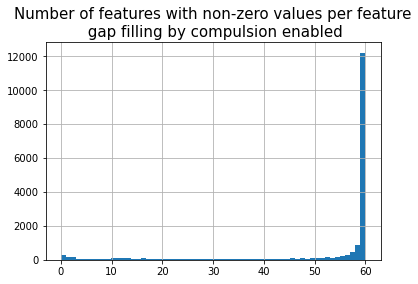

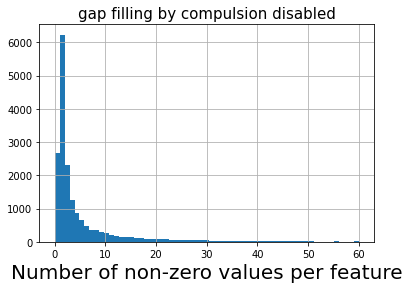

In [123]:
neg['num_nonzero'].hist(bins=61, )
plt.title('Number of features with non-zero values per feature\n gap filling by compulsion enabled', fontsize=15)
# plt.xlabel('Number of non-zero values', fontsize=20)
plt.figure()
negwogfc['num_nonzero'].hist(bins=61)
plt.title('gap filling by compulsion disabled', fontsize=15)
plt.xlabel('Number of non-zero values per feature', fontsize=20)

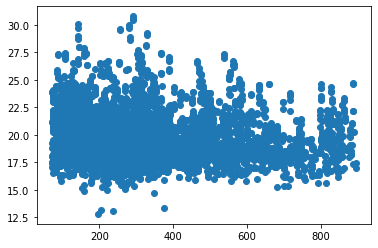

In [124]:
plt.scatter(filt['Average Mz'], np.log2(filt['mean']))

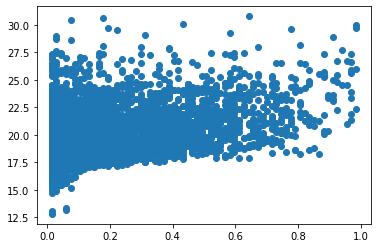

In [125]:
plt.scatter(filt['Fill %'], np.log2(filt['mean']))

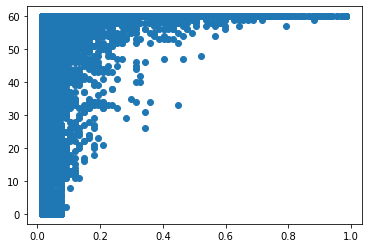

In [126]:
plt.scatter(neg['Fill %'], neg['num_nonzero'])

In [127]:
filt.loc[filt['Alignment ID'] == 551]

,Alignment ID,Average Rt(min),Average Mz,Metabolite name,Adduct type,Post curation result,Fill %,MS/MS assigned,Reference RT,Reference m/z,...,D_R.1,N_F.1,N_R.1,num_nonzero,mean,std,rsd,log_mean,log_std,log_rsd
551,551,9.975,89.0233,LACTIC ACID,[M-H]-,ion correlated with 548; similar chromatogram ...,0.403,True,NaN,89.02442,...,3.480495e+07,8.660245e+07,3.883295e+07,60,1.639089e+08,6.331582e+07,0.386287,27.169757,0.615836,0.022666


<AxesSubplot:>

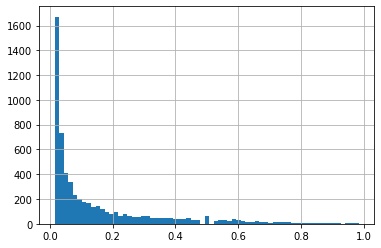

In [128]:
filt['Fill %'].hist(bins=67)

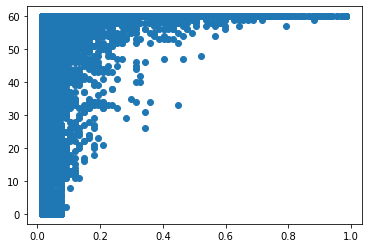

In [129]:
plt.scatter(neg['Fill %'], neg['num_nonzero'])

<AxesSubplot:>

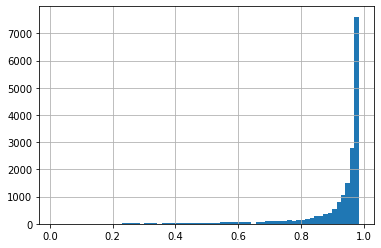

In [130]:
(1 - neg['Fill %']).hist(bins=68)

In [131]:
(neg['Fill %'] > 0.2).value_counts()

False    16136
True      2076
Name: Fill %, dtype: int64

## Reshape data to work with imputer  

https://metabolomics.cc.hawaii.edu/software/MetImp/https://pypi.org/project/missingpy/

Based on the conclusion of this JPR paper (https://pubs.acs.org/doi/10.1021/acs.jproteome.5b00981) use of MCAR/MAR imputation is likely to work well, even if the values are more closely distributed as MNAR (where mostly low intensity peaks are missing, as opposed to missing randomly across the intensity range). 

Random Forest imputation is associated with MCAR/MAR imputation. However, RF does not work well with p >> n in the imputation case (where number of features is much greater than number of samples, in this case, 10,000 features >> 60 samples) 

Therefore, try using KNN for imputation.

<AxesSubplot:>

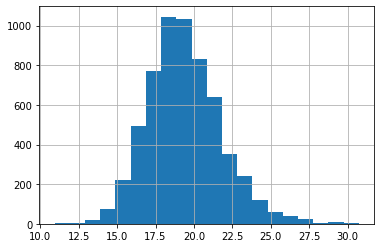

In [119]:
filt['log_mean'] = np.log2(filt[data_cols] + 1).mean(axis=1)
filt['log_mean'].hist(bins=20)

<AxesSubplot:>

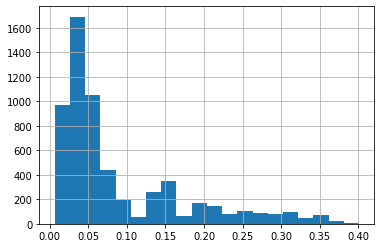

In [135]:
# Some of the RSDs are high, but are these spurious features or just real variation? 

filt['log_std'] = np.log2(filt[data_cols] + 1).std(axis=1)
filt['log_rsd'] = filt['log_std']/filt['log_mean']
filt['log_rsd'].hist(bins=20)

In [140]:
# Sample some of the rows where log_rsd > 0.2 and inspect in MS-Dial interface

filt.loc[(filt['log_rsd'] > 0.2) & (filt['Alignment ID'] < 3000)].sample(10).sort_values('Alignment ID')

,Alignment ID,Average Rt(min),Average Mz,Metabolite name,Adduct type,Post curation result,Fill %,MS/MS assigned,Reference RT,Reference m/z,...,N_F.1,N_R.1,num_nonzero,mean,std,rsd,log_mean,log_std,log_rsd,log_human_rsd
1,1,1.926,71.01269,Unknown,[M-H]-,ion correlated with 13; similar chromatogram i...,0.045,False,NaN,NaN,...,47348.360714,6.278136e+04,58,1.402699e+05,1.490266e+05,1.062428,15.851774,3.347780,0.211193,NaN
12,12,1.381,71.01279,Unknown,[M-H]-,similar chromatogram in higher mz_15439,0.104,False,NaN,NaN,...,33042.760197,1.527579e+05,54,1.853462e+05,2.123876e+05,1.145896,15.034549,5.394870,0.358832,NaN
130,130,12.650,75.28672,Unknown,[M-H]-,NaN,0.045,False,NaN,NaN,...,103729.662908,1.135071e+05,58,1.290386e+05,1.075764e+05,0.833676,15.605814,3.611028,0.231390,0.064136
138,138,1.728,75.28937,Unknown,[M-H]-,NaN,0.015,False,NaN,NaN,...,355545.875966,3.200708e+05,58,3.085532e+05,2.789696e+05,0.904122,16.838008,3.711268,0.220410,0.048645
145,145,14.184,75.29591,Unknown,[M-H]-,similar chromatogram in higher mz_17941; simil...,0.119,False,NaN,NaN,...,169897.264942,3.380190e+05,54,2.549721e+05,2.514249e+05,0.986088,15.303228,5.664607,0.370158,0.056040
362,362,1.583,83.42492,Unknown,[M-H]-,similar chromatogram in higher mz_12516; simil...,0.045,False,NaN,NaN,...,282156.494065,1.835103e+05,58,3.544537e+05,3.645438e+05,1.028466,16.492047,4.137128,0.250856,0.067411
668,668,12.623,93.04465,Unknown,[M-H]-,NaN,0.015,False,NaN,NaN,...,123260.714150,1.368224e+05,56,1.489597e+05,1.451405e+05,0.974361,15.545543,4.417566,0.284169,NaN
1791,1791,12.788,115.08659,Unknown,[M-H]-,found in higher mz's MsMs_6828; found in highe...,0.015,False,NaN,NaN,...,336667.676949,1.604178e+05,54,4.543805e+05,2.872374e+05,0.632152,16.685399,5.851948,0.350723,NaN
2497,2497,12.769,128.89110,Unknown,[M-H]-,ion correlated with 2548; ion correlated with ...,0.418,True,NaN,NaN,...,777304.236713,5.301072e+06,58,2.177153e+06,3.341418e+06,1.534765,18.631820,4.242686,0.227712,NaN
2549,2549,12.764,130.88820,Unknown,[M-H]-,ion correlated with 2548; ion correlated with ...,0.552,True,NaN,NaN,...,836424.443014,5.303485e+06,58,2.349990e+06,3.510169e+06,1.493695,18.944550,4.174292,0.220343,NaN


In [145]:
filt.loc[filt['Alignment ID'] == 2497]['Post curation result'].values

array(['ion correlated with 2548; ion correlated with 2498; ion correlated with 2549; similar chromatogram in higher mz_6611; similar chromatogram in higher mz_10286; similar chromatogram in higher mz_6279'],
      dtype=object)

In [181]:
type(indexes[0])

int

## Use MS-Dial 'ion correlated with X' to filter out more rows


In [305]:
indexes = list(filt.index)

ion_corr_with = defaultdict(lambda: [])
sim_chrom = defaultdict(lambda: [])
found_in_ms2 = defaultdict(lambda: [])

for index, row in filt.iterrows():
#     print(row['Post curation result'])
    try:
        split = row['Post curation result'].split(';')
    except AttributeError:
        continue
    for s in split:
        if 'ion correlated with ' in s:
            corr_with_index = int(s.split(' ')[-1])
            if corr_with_index in indexes:
                ion_corr_with[index].append(corr_with_index)
            
        if 'similar chromatogram in' in s:
            sim_chrom_index = int(s.split('_')[-1])
            if sim_chrom_index in indexes:
                sim_chrom[index].append(sim_chrom_index)
        
        if "found in higher mz's MsMs" in s:
            msms_index = int(s.split('_')[-1])
            if msms_index in indexes:
                found_in_ms2[index].append(msms_index)
            
#     print(split)
    
#     if index > 1000:
#         break

In [235]:
ion_corr_with[18197]

[18198]

In [193]:
# dict(sim_chrom)

In [192]:
# dict(found_in_ms2)

In [248]:
filt.loc[filt['Alignment ID'] == 5825]['Post curation result'].values

array([nan], dtype=object)

### ion_corr_with dictionary comes from the MS-Dial dataframe. 

For each entry in the ion_corr_with dictionary:

1. Take the key and all values in the list and Combine them into a tuple
2. Add tuple to an "ion groups" list
3. Add the key and all values as individual integers to a set()
4. if key in set(): continue
    1. Because each ion is perfectly interconnected among all other correlated ions, it's safe to add to set and never check again 
   
Alternatively: you could add all tuples, then sort all tuples, then remove duplicates by creating a set from that 

In [333]:
# Finds all of the connected ion groups from the MS-Dial "Post Curation Result" column
# For each connected index pair found in the parsing code above, add an edge in a graph between the two indexes.
# Then use networkx connected_components() to get all the groups that are isolated islands in the graph
# Finally, use set().difference() to get all the features that were not in a group (ie not connected to any other ion)

import networkx
from itertools import permutations, combinations

g = networkx.Graph()

for key, value in ion_corr_with.items():
    group = value.copy()
    group.append(key)
    for combo in combinations(group, 2):
        g.add_edge(combo[0], combo[1])
    
ion_groups = sorted(list(sorted(list(x)) for x in networkx.algorithms.components.connected_components(g)))

# print(len(ion_groups))
# print(ion_groups)

in_ion_group = set()
for group in ion_groups:
    for index in group:
        in_ion_group.add(index)

all_indexes = set(indexes)

not_in_ion_group = sorted(list(all_indexes.difference(in_ion_group)))

In [347]:
print(filt.loc[[1,13]]['log_mean'].max())
print(filt.loc[[1,13]]['log_mean'].values)
filt.loc[[1,13]]['log_mean'].idxmax()

16.12228951760915
[15.85177379 16.12228952]


13

In [361]:
l = [18.69597725, 17.89809249, 20.19079535, 17.61844434, 15.00847826]
x = 0
for thing in l:
    x += 2**thing
print(np.log2(x))


21.001928115114858


In [367]:
print(len(in_ion_group))

2239


In [375]:
group_idxmax = []
for group in ion_groups:
    
    if filt.loc[group]['Average Rt(min)'].max() - filt.loc[group]['Average Rt(min)'].min() > 0.2:
        print('RT AHHHH')
    
    if filt.loc[group]['log_mean'].max() - filt.loc[group]['log_mean'].min() > 3:
        print(filt.loc[group]['log_mean'].max())
        print(filt.loc[group]['log_mean'].values)
        print(filt.loc[group]['log_mean'].idxmax())
        print('\n')
    
    m = filt.loc[group]['num_nonzero'].max()
    if m < 55:
        print(m)
    
    group_idxmax.append(filt.loc[group]['log_mean'].idxmax())

20.190795349272296
[18.69597725 17.89809249 20.19079535 17.61844434 15.00847826]
12927


54
54
54
20.8773509300715
[20.87735093 18.81012987 17.26797613]
12929


RT AHHHH
54
54
54
54
18.890905864063257
[16.18410904 14.97523098 15.21579343 15.38070287 16.94329568 18.89090586]
18003


54
54
54
54
RT AHHHH


In [377]:
len(group_idxmax)

949

In [376]:
len(not_in_ion_group)

3747

In [382]:
ion_group_filtered = sorted(group_idxmax + not_in_ion_group)

In [385]:
filt = filt.loc[ion_group_filtered]
filt

,Alignment ID,Average Rt(min),Average Mz,Metabolite name,Adduct type,Post curation result,Fill %,MS/MS assigned,Reference RT,Reference m/z,...,N_F.1,N_R.1,num_nonzero,mean,std,rsd,log_mean,log_std,log_rsd,log_human_rsd
6,6,10.426,71.01276,Unknown,[M-H]-,NaN,0.060,True,NaN,NaN,...,7.798368e+04,4.821844e+04,60,2.745132e+05,1.657824e+05,0.603914,17.769151,1.031538,0.058052,0.040791
10,10,9.278,71.01279,Unknown,[M-H]-,ion correlated with 3,0.328,True,NaN,NaN,...,5.405630e+05,1.419123e+06,60,2.364216e+06,2.562558e+06,1.083893,20.267141,1.737161,0.085713,0.053483
11,11,10.346,71.01279,Unknown,[M-H]-,NaN,0.015,True,NaN,NaN,...,9.242140e+04,4.638612e+04,60,2.712991e+05,1.669019e+05,0.615195,17.742938,1.081461,0.060952,0.051134
12,12,1.381,71.01279,Unknown,[M-H]-,similar chromatogram in higher mz_15439,0.104,False,NaN,NaN,...,3.304276e+04,1.527579e+05,54,1.853462e+05,2.123876e+05,1.145896,15.034549,5.394870,0.358832,NaN
13,13,1.970,71.01279,Unknown,[M-H]-,ion correlated with 1,0.045,False,NaN,NaN,...,2.054241e+04,8.786192e+04,58,1.718086e+05,1.738090e+05,1.011643,16.122290,3.399320,0.210846,0.125333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18203,18203,2.399,887.55609,w/o MS2:Phosphatidylinositol 18:0-20:3,[M-H]-,NaN,0.045,False,NaN,887.56000,...,1.439748e+06,1.104574e+06,60,4.831443e+06,1.970959e+06,0.407944,22.085488,0.601153,0.027219,0.031082
18204,18204,2.465,887.56201,w/o MS2:PI 38:3,[M-H]-,NaN,0.149,False,NaN,887.56061,...,1.121405e+06,9.817370e+05,60,4.693236e+06,1.976740e+06,0.421189,22.038686,0.609940,0.027676,0.029080
18205,18205,2.468,888.56647,w/o MS2:PC 40:8,[M-H]-,NaN,0.194,False,NaN,888.57202,...,3.594331e+05,4.162421e+05,60,1.217697e+06,6.064192e+05,0.498005,20.019000,0.802111,0.040067,0.029379
18210,18210,16.404,895.01520,Unknown,[M-H]-,NaN,0.045,False,NaN,NaN,...,9.412051e+04,8.873264e+04,60,1.289493e+05,8.780035e+04,0.680891,16.572492,1.176893,0.071015,NaN


,Alignment ID,Average Rt(min),Average Mz,Metabolite name,Adduct type,Post curation result,Fill %,MS/MS assigned,Reference RT,Reference m/z,...,N_F.1,N_R.1,num_nonzero,mean,std,rsd,log_mean,log_std,log_rsd,log_human_rsd
1963,1963,1.579,117.63911,Unknown,[M-H]-,NaN,0.075,False,NaN,NaN,...,6.422659e+05,3.985565e+05,60,5.318524e+05,5.261833e+05,0.989341,17.735507,2.533916,0.142872,0.236747
2096,2096,1.038,120.05559,Unknown,[M-H2O-H]-,ion correlated with 2648; adduct linked to 311...,0.030,True,NaN,NaN,...,3.838164e+06,6.421890e+06,60,5.306376e+06,4.503835e+06,0.848759,21.751258,1.862484,0.085626,0.200045
2774,2774,15.464,133.01314,w/o MS2:D-(+)-Malic acid,[M-H]-,NaN,0.015,True,NaN,133.01372,...,2.397105e+05,9.785551e+04,60,3.144323e+05,3.788963e+05,1.205017,17.324700,1.833569,0.105836,0.230026
4012,4012,12.759,154.06122,HISTIDINE,[M-H]-,NaN,0.045,True,NaN,154.06219,...,3.157627e+06,6.288277e+06,60,1.311092e+07,9.154460e+06,0.698232,23.005037,2.139512,0.093002,0.203051
4966,4966,0.901,169.83315,Unknown,[M-H]-,NaN,0.030,False,NaN,NaN,...,3.170523e+05,2.356958e+05,60,5.234116e+05,3.262456e+05,0.623306,18.720428,0.994238,0.053110,0.200649
5747,5747,1.651,183.06683,w/o MS2:Antiarol,[M-H]-,NaN,0.030,False,NaN,183.06079,...,1.706181e+05,9.734389e+04,60,3.495771e+05,6.032250e+05,1.725585,17.223844,2.015459,0.117016,0.227012
7543,7543,12.597,216.03072,"w/o MS2:2,3-Quinolinedicarboxylic acid",[M-H]-,NaN,0.030,False,NaN,216.03020,...,1.166739e+06,1.850332e+05,57,3.338852e+05,4.888390e+05,1.464093,16.008057,4.542614,0.283770,0.203893
12138,12138,14.595,307.16565,w/o MS2:Bestatin,[M-H]-,NaN,0.030,False,NaN,307.16599,...,1.006685e+05,1.468096e+05,60,1.268496e+05,1.064070e+05,0.838844,16.475197,1.225400,0.074378,0.221992
13092,13092,12.599,334.85272,Unknown,[M-H]-,ion correlated with 13093,0.179,False,NaN,NaN,...,2.642462e+05,2.092427e+05,54,2.868158e+05,2.435574e+05,0.849177,16.000621,5.559209,0.347437,0.231013
14179,14179,14.621,368.98267,Unknown,[M-H]-,NaN,0.030,False,NaN,NaN,...,5.434207e+05,9.578851e+04,60,6.323911e+05,3.869201e+05,0.611837,19.061274,0.751629,0.039432,0.214606


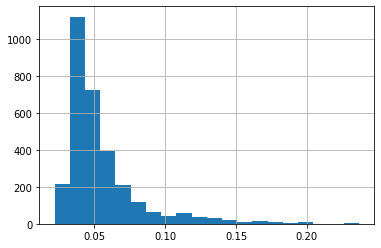

In [387]:
# Human control RSDs look good

filt['log_human_rsd'] = np.log2(filt[human_cols]).std(axis=1) / np.log2(filt[human_cols]).mean(axis=1)
filt['log_human_rsd'].hist(bins=20)
filt.loc[filt['log_human_rsd'] > 0.2]

In [390]:
float('-inf')

-inf

In [391]:
raw = filt.filter(regex='2021').T
raw = np.log2(raw)
raw = raw.replace({float('-inf'):np.nan})
# raw.insert(0, column='group', value=1)
display(raw)

trees = ExtraTreesRegressor(n_estimators=5, random_state=1000, max_features='sqrt')

trees_imputer = IterativeImputer(estimator=trees, random_state=1000)
trees_imp = trees_imputer.fit_transform(raw)

,6,10,11,12,13,21,25,27,30,32,...,18198,18199,18200,18201,18202,18203,18204,18205,18210,18211
20210831_KAO_HILIC_ACN_20210831232610,15.353595,15.470595,14.819081,NaN,NaN,18.956118,15.542155,17.203883,19.421574,18.637523,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20210831_KAO_HILIC_extraction_blank_1,8.933691,14.213028,9.567956,14.911345,15.320589,17.208225,13.803828,18.653968,18.420322,18.017749,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20210831_KAO_HILIC_human_plasma_1,20.786999,18.514541,20.270186,13.954287,15.224981,17.632598,18.475092,16.865902,19.748370,18.232224,...,21.900338,19.219109,19.894722,25.563084,25.563084,23.655146,23.655146,22.230577,NaN,13.169612
20210831_KAO_HILIC_human_plasma_2,20.275149,18.623253,20.861016,NaN,14.593800,20.144658,17.313539,19.795767,21.436872,22.043709,...,21.026844,19.353106,19.319024,24.502296,24.777947,22.498618,22.769750,20.963628,13.807154,15.247037
20210831_KAO_HILIC_human_plasma_3,21.064804,18.770909,20.431166,12.233320,14.876469,17.498242,19.082505,20.536241,19.898768,19.134845,...,20.938288,19.745344,16.906914,24.520695,24.795440,22.782800,22.515579,20.893453,13.836248,15.976810
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20210831_KAO_HILIC_T1102M_20210406_9wk_RBG,17.461847,20.646620,17.588019,15.559019,16.963833,18.706847,20.066556,19.999704,19.545694,20.509863,...,21.495546,19.061150,18.358900,25.086969,24.753996,22.431502,22.747787,20.739202,16.407550,17.964189
20210831_KAO_HILIC_T1102M_20210410_10wk_FBG,17.031992,19.623054,17.404759,15.498039,17.995905,19.539846,19.533761,19.965377,21.297258,20.397709,...,21.300558,18.669013,18.085000,25.314846,24.894947,22.262947,22.562983,20.793040,15.625081,17.825841
20210831_KAO_HILIC_T1102M_20210413_10wk_RBG,18.078500,18.033692,17.820478,14.876565,14.954696,19.700502,20.031646,19.310014,19.892393,20.333567,...,21.463251,18.734931,17.037751,24.514750,24.892424,22.506454,22.192765,20.445880,17.318040,17.402729
20210831_KAO_HILIC_T112M_20210330_8wk_RBG,18.485861,21.576394,18.623610,19.233276,18.466658,20.007764,19.668172,19.778533,20.780839,22.129803,...,21.202515,18.715657,16.968712,24.898796,24.528909,22.293908,22.604483,20.782188,16.840729,16.653699


C:\Users\bjanderson23\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:701: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  ConvergenceWarning,


In [412]:
raw

,6,10,11,12,13,21,25,27,30,32,...,18198,18199,18200,18201,18202,18203,18204,18205,18210,18211
20210831_KAO_HILIC_ACN_20210831232610,15.353595,15.470595,14.819081,NaN,NaN,18.956118,15.542155,17.203883,19.421574,18.637523,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20210831_KAO_HILIC_extraction_blank_1,8.933691,14.213028,9.567956,14.911345,15.320589,17.208225,13.803828,18.653968,18.420322,18.017749,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20210831_KAO_HILIC_human_plasma_1,20.786999,18.514541,20.270186,13.954287,15.224981,17.632598,18.475092,16.865902,19.748370,18.232224,...,21.900338,19.219109,19.894722,25.563084,25.563084,23.655146,23.655146,22.230577,NaN,13.169612
20210831_KAO_HILIC_human_plasma_2,20.275149,18.623253,20.861016,NaN,14.593800,20.144658,17.313539,19.795767,21.436872,22.043709,...,21.026844,19.353106,19.319024,24.502296,24.777947,22.498618,22.769750,20.963628,13.807154,15.247037
20210831_KAO_HILIC_human_plasma_3,21.064804,18.770909,20.431166,12.233320,14.876469,17.498242,19.082505,20.536241,19.898768,19.134845,...,20.938288,19.745344,16.906914,24.520695,24.795440,22.782800,22.515579,20.893453,13.836248,15.976810
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20210831_KAO_HILIC_T1102M_20210406_9wk_RBG,17.461847,20.646620,17.588019,15.559019,16.963833,18.706847,20.066556,19.999704,19.545694,20.509863,...,21.495546,19.061150,18.358900,25.086969,24.753996,22.431502,22.747787,20.739202,16.407550,17.964189
20210831_KAO_HILIC_T1102M_20210410_10wk_FBG,17.031992,19.623054,17.404759,15.498039,17.995905,19.539846,19.533761,19.965377,21.297258,20.397709,...,21.300558,18.669013,18.085000,25.314846,24.894947,22.262947,22.562983,20.793040,15.625081,17.825841
20210831_KAO_HILIC_T1102M_20210413_10wk_RBG,18.078500,18.033692,17.820478,14.876565,14.954696,19.700502,20.031646,19.310014,19.892393,20.333567,...,21.463251,18.734931,17.037751,24.514750,24.892424,22.506454,22.192765,20.445880,17.318040,17.402729
20210831_KAO_HILIC_T112M_20210330_8wk_RBG,18.485861,21.576394,18.623610,19.233276,18.466658,20.007764,19.668172,19.778533,20.780839,22.129803,...,21.202515,18.715657,16.968712,24.898796,24.528909,22.293908,22.604483,20.782188,16.840729,16.653699


In [414]:
fitted = pd.DataFrame(trees_imp)
fitted.columns = raw.columns
fitted.index = raw.index
fitted.to_csv(r'..\data\processed\metabolomics_msdial_imputed_filtered.csv')

In [392]:
# KNN requires a huge memory footprint which quickly runs out. Who knows how long it takes? 

knn = KNeighborsRegressor()
knn_imputer = IterativeImputer(estimator=knn, random_state=1000)
knn_imp = knn_imputer.fit_transform(raw)

KeyboardInterrupt: 

In [22]:
imp.shape

(67, 1000)

In [ ]:
neg

<AxesSubplot:>

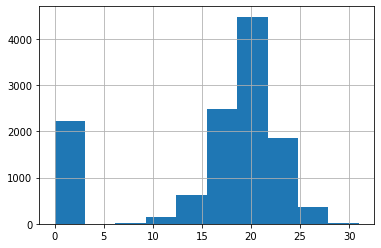

In [210]:
neg[blank_col].hist(range=(0, 31))

<AxesSubplot:>

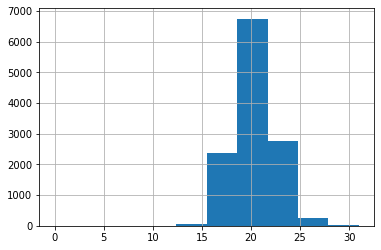

In [211]:
neg['mean'] = neg[data_cols].mean(axis=1)
neg['mean'].hist(range=(0, 31))

In [212]:
neg['gt_3x_blank'] = neg['mean'] > 1.585 * neg[blank_col]
neg['gt_3x_blank'].value_counts()

False    9794
True     2424
Name: gt_3x_blank, dtype: int64

<AxesSubplot:ylabel='Frequency'>

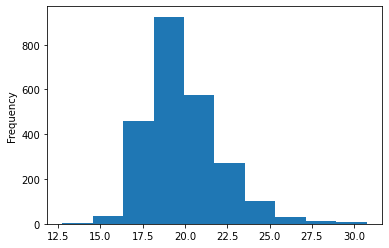

In [213]:
neg.loc[neg['gt_3x_blank'] == True]['mean'].plot.hist()

In [215]:
neg.loc[neg['gt_3x_blank'] == True]

,20210831_KAO_HILIC_ACN_20210831232610,20210831_KAO_HILIC_extraction_blank_1,20210831_KAO_HILIC_human_plasma_1,20210831_KAO_HILIC_human_plasma_2,20210831_KAO_HILIC_human_plasma_3,20210831_KAO_HILIC_human_plasma_4,20210831_KAO_HILIC_human_plasma_5,20210831_KAO_HILIC_T1060M_20210322_8wk_FBG,20210831_KAO_HILIC_T1060M_20210325_8wk_RBG,20210831_KAO_HILIC_T1060M_20210329_9wk_FBG,...,20210831_KAO_HILIC_T1102M_20210327_8wk_FBG,20210831_KAO_HILIC_T1102M_20210402_9wk_FBG,20210831_KAO_HILIC_T1102M_20210406_9wk_RBG,20210831_KAO_HILIC_T1102M_20210410_10wk_FBG,20210831_KAO_HILIC_T1102M_20210413_10wk_RBG,20210831_KAO_HILIC_T112M_20210330_8wk_RBG,20210831_KAO_HILIC_T193M20210406_9wk_RBG,rsd,mean,gt_3x_blank
6,15.353629,8.936638,20.787000,20.275150,21.064805,21.161065,21.184801,17.054996,18.908466,17.772379,...,17.128810,17.010801,17.461855,17.032003,18.078505,18.485865,17.433121,0.058052,17.769151,True
11,14.819131,9.569856,20.270187,20.861016,20.431167,20.579586,20.566416,15.743046,18.908466,18.169754,...,18.012428,17.088581,17.588026,17.404767,17.820484,18.623614,17.568995,0.060952,17.742938,True
129,13.671873,0.000000,12.715533,15.025399,15.009260,14.323055,14.790298,14.927778,17.953924,15.988152,...,17.663906,18.077327,16.986386,17.251371,16.633464,16.386907,17.263984,0.084271,16.654431,True
168,16.277033,0.000000,15.421144,17.021934,18.793029,18.766001,17.254890,19.311533,17.681554,17.225753,...,16.872627,19.162310,17.698800,19.524515,18.897151,17.924581,19.329328,0.081308,18.245818,True
169,16.277033,0.000000,17.514252,18.944689,19.256421,19.227903,17.254890,18.964338,18.852130,19.236481,...,18.309592,19.600283,18.910019,19.524515,19.221014,18.925995,19.329328,0.072789,18.819755,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18203,0.000000,0.000000,23.655146,22.498619,22.782800,23.043839,23.071493,21.241245,20.533270,21.679371,...,22.061995,22.804068,22.431502,22.262947,22.506455,22.293909,22.352056,0.027219,22.085488,True
18204,0.000000,0.000000,23.655146,22.769750,22.515579,22.783197,22.821672,21.480588,20.788900,21.425487,...,21.810796,22.494756,22.747787,22.562983,22.192766,22.604483,22.085744,0.027676,22.038686,True
18205,0.000000,0.000000,22.230577,20.963628,20.893453,21.259276,21.462442,19.559168,18.215760,19.151297,...,19.839155,20.792058,20.739203,20.793040,20.445881,20.782189,20.160931,0.040067,20.019000,True
18210,0.000000,0.000000,0.000000,13.807254,13.836346,0.000000,0.000000,18.056505,16.547828,17.986292,...,14.032476,16.385475,16.407567,15.625109,17.318048,16.840741,15.457701,0.071015,16.572492,True


<AxesSubplot:ylabel='Frequency'>

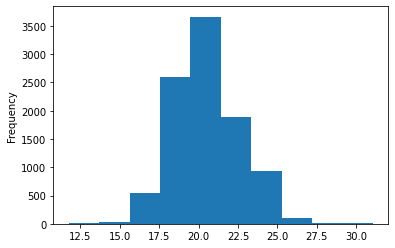

In [214]:
neg.loc[neg['gt_3x_blank'] == False]['mean'].plot.hist()

## With the MSDial data, you only lose 6k out of 18k rows when you drop all the rows with any zeroes in the 60 main files. 

### Important question is how do we best use the 5 human plasma QC samples to filter?

### I feel it's unsound to impute values for the QCs too because 

## Calculate RSD for human plasma QCs

<AxesSubplot:>

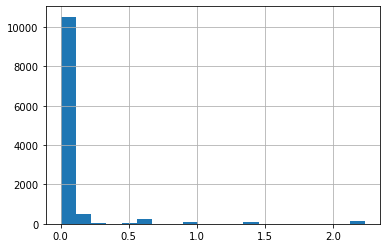

In [229]:
neg['qc_rsd'] = neg.filter(regex='human').std(axis=1) / neg.filter(regex='human').mean(axis=1)
neg['qc_rsd'].hist(bins=20)

<AxesSubplot:>

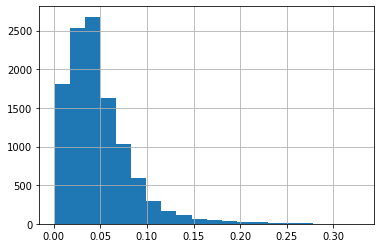

In [228]:
neg.loc[neg['qc_nonzero'] == 5]['qc_rsd'].hist(bins=20)

## How many rows in the 5 human plasma QC samples have no zeroes?

In [219]:
neg['qc_nonzero'] = neg.filter(regex='human').astype(bool).sum(axis=1)
neg['qc_nonzero'].value_counts()

5    11046
0      548
4      309
1      153
3       85
2       77
Name: qc_nonzero, dtype: int64

In [222]:
neg.loc[neg['qc_nonzero'] == 5]

,20210831_KAO_HILIC_ACN_20210831232610,20210831_KAO_HILIC_extraction_blank_1,20210831_KAO_HILIC_human_plasma_1,20210831_KAO_HILIC_human_plasma_2,20210831_KAO_HILIC_human_plasma_3,20210831_KAO_HILIC_human_plasma_4,20210831_KAO_HILIC_human_plasma_5,20210831_KAO_HILIC_T1060M_20210322_8wk_FBG,20210831_KAO_HILIC_T1060M_20210325_8wk_RBG,20210831_KAO_HILIC_T1060M_20210329_9wk_FBG,...,20210831_KAO_HILIC_T1102M_20210402_9wk_FBG,20210831_KAO_HILIC_T1102M_20210406_9wk_RBG,20210831_KAO_HILIC_T1102M_20210410_10wk_FBG,20210831_KAO_HILIC_T1102M_20210413_10wk_RBG,20210831_KAO_HILIC_T112M_20210330_8wk_RBG,20210831_KAO_HILIC_T193M20210406_9wk_RBG,rsd,mean,gt_3x_blank,qc_nonzero
2,15.384177,16.553989,23.554601,23.538554,23.657072,23.745994,23.784401,22.866606,24.436403,22.851987,...,22.998627,24.516932,23.411132,24.381591,24.633240,23.468362,0.029359,23.753253,False,5
3,15.470627,15.229758,18.059429,18.623256,18.477774,18.653153,18.681434,22.504828,23.096071,22.793260,...,20.750656,20.646621,19.285599,18.033697,21.734772,18.607753,0.088221,20.212180,False,5
5,16.551618,17.135880,23.554601,23.538554,23.657072,23.745994,23.784401,22.866606,24.436403,22.851987,...,22.998627,24.516932,23.411132,24.381591,24.302560,23.468362,0.029360,23.715611,False,5
6,15.353629,8.936638,20.787000,20.275150,21.064805,21.161065,21.184801,17.054996,18.908466,17.772379,...,17.010801,17.461855,17.032003,18.078505,18.485865,17.433121,0.058052,17.769151,True,5
8,18.139406,14.956013,18.393902,17.776369,19.094995,18.943751,18.073979,17.021403,18.331490,18.968596,...,17.748553,18.685512,18.351220,18.381948,19.553057,19.119498,0.045237,18.256108,False,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18201,0.000000,0.000000,25.563084,24.502296,24.520695,24.752625,24.711461,24.287376,23.256209,23.880013,...,25.087165,25.086969,25.314846,24.514750,24.898796,24.401849,0.025392,24.457123,True,5
18202,0.000000,0.000000,25.563084,24.777947,24.795440,25.016021,24.976322,23.937902,22.967634,24.226056,...,25.465338,24.753996,24.894947,24.892424,24.528909,24.754077,0.023130,24.591609,True,5
18203,0.000000,0.000000,23.655146,22.498619,22.782800,23.043839,23.071493,21.241245,20.533270,21.679371,...,22.804068,22.431502,22.262947,22.506455,22.293909,22.352056,0.027219,22.085488,True,5
18204,0.000000,0.000000,23.655146,22.769750,22.515579,22.783197,22.821672,21.480588,20.788900,21.425487,...,22.494756,22.747787,22.562983,22.192766,22.604483,22.085744,0.027676,22.038686,True,5


## What's the overlap between rows with low QC RSD and rows with lots of QC zeroes? 

In [255]:
neg.loc[((neg['qc_rsd'] < 0.25) & (neg['qc_nonzero'] == 5)) & (neg['gt_3x_blank'] == True)]

,20210831_KAO_HILIC_ACN_20210831232610,20210831_KAO_HILIC_extraction_blank_1,20210831_KAO_HILIC_human_plasma_1,20210831_KAO_HILIC_human_plasma_2,20210831_KAO_HILIC_human_plasma_3,20210831_KAO_HILIC_human_plasma_4,20210831_KAO_HILIC_human_plasma_5,20210831_KAO_HILIC_T1060M_20210322_8wk_FBG,20210831_KAO_HILIC_T1060M_20210325_8wk_RBG,20210831_KAO_HILIC_T1060M_20210329_9wk_FBG,...,20210831_KAO_HILIC_T1102M_20210406_9wk_RBG,20210831_KAO_HILIC_T1102M_20210410_10wk_FBG,20210831_KAO_HILIC_T1102M_20210413_10wk_RBG,20210831_KAO_HILIC_T112M_20210330_8wk_RBG,20210831_KAO_HILIC_T193M20210406_9wk_RBG,rsd,mean,gt_3x_blank,qc_nonzero,qc_rsd
6,15.353629,8.936638,20.787000,20.275150,21.064805,21.161065,21.184801,17.054996,18.908466,17.772379,...,17.461855,17.032003,18.078505,18.485865,17.433121,0.058052,17.769151,True,5,0.018216
11,14.819131,9.569856,20.270187,20.861016,20.431167,20.579586,20.566416,15.743046,18.908466,18.169754,...,17.588026,17.404767,17.820484,18.623614,17.568995,0.060952,17.742938,True,5,0.010608
129,13.671873,0.000000,12.715533,15.025399,15.009260,14.323055,14.790298,14.927778,17.953924,15.988152,...,16.986386,17.251371,16.633464,16.386907,17.263984,0.084271,16.654431,True,5,0.067405
168,16.277033,0.000000,15.421144,17.021934,18.793029,18.766001,17.254890,19.311533,17.681554,17.225753,...,17.698800,19.524515,18.897151,17.924581,19.329328,0.081308,18.245818,True,5,0.080392
169,16.277033,0.000000,17.514252,18.944689,19.256421,19.227903,17.254890,18.964338,18.852130,19.236481,...,18.910019,19.524515,19.221014,18.925995,19.329328,0.072789,18.819755,True,5,0.052882
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18201,0.000000,0.000000,25.563084,24.502296,24.520695,24.752625,24.711461,24.287376,23.256209,23.880013,...,25.086969,25.314846,24.514750,24.898796,24.401849,0.025392,24.457123,True,5,0.017552
18202,0.000000,0.000000,25.563084,24.777947,24.795440,25.016021,24.976322,23.937902,22.967634,24.226056,...,24.753996,24.894947,24.892424,24.528909,24.754077,0.023130,24.591609,True,5,0.012726
18203,0.000000,0.000000,23.655146,22.498619,22.782800,23.043839,23.071493,21.241245,20.533270,21.679371,...,22.431502,22.262947,22.506455,22.293909,22.352056,0.027219,22.085488,True,5,0.018620
18204,0.000000,0.000000,23.655146,22.769750,22.515579,22.783197,22.821672,21.480588,20.788900,21.425487,...,22.747787,22.562983,22.192766,22.604483,22.085744,0.027676,22.038686,True,5,0.018956


## Better question: How many QCs have all 5 samples

In [254]:
neg.loc[neg['gt_3x_blank']]['qc_nonzero'].value_counts()

5    1497
0     531
4     155
1     128
3      58
2      55
Name: qc_nonzero, dtype: int64

In [75]:
df['data_avg'] = df[data_cols].mean(axis=1)
df['data_avg']

C:\Users\bjanderson23\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


0        1.313160e+05
1        1.402699e+05
2        1.590286e+07
3        2.326267e+06
4        1.563518e+05
             ...     
18207    1.915792e+04
18208    3.804277e+04
18209    6.786033e+04
18210    1.289493e+05
18211    1.748940e+05
Name: data_avg, Length: 18212, dtype: float64

In [77]:
df['blank_filt'] = df['data_avg'] > df['20210831_KAO_HILIC_extraction_blank_1']

C:\Users\bjanderson23\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [85]:
df['std'] = df[data_cols].std(axis=1)
df['std']

C:\Users\bjanderson23\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


0        2.222435e+05
1        1.490266e+05
2        7.948135e+06
3        2.567073e+06
4        1.675624e+05
             ...     
18207    6.308471e+04
18208    1.215713e+05
18209    1.653560e+05
18210    8.780035e+04
18211    9.250480e+04
Name: std, Length: 18212, dtype: float64

In [257]:
neg

,20210831_KAO_HILIC_ACN_20210831232610,20210831_KAO_HILIC_extraction_blank_1,20210831_KAO_HILIC_human_plasma_1,20210831_KAO_HILIC_human_plasma_2,20210831_KAO_HILIC_human_plasma_3,20210831_KAO_HILIC_human_plasma_4,20210831_KAO_HILIC_human_plasma_5,20210831_KAO_HILIC_T1060M_20210322_8wk_FBG,20210831_KAO_HILIC_T1060M_20210325_8wk_RBG,20210831_KAO_HILIC_T1060M_20210329_9wk_FBG,...,20210831_KAO_HILIC_T1102M_20210406_9wk_RBG,20210831_KAO_HILIC_T1102M_20210410_10wk_FBG,20210831_KAO_HILIC_T1102M_20210413_10wk_RBG,20210831_KAO_HILIC_T112M_20210330_8wk_RBG,20210831_KAO_HILIC_T193M20210406_9wk_RBG,rsd,mean,gt_3x_blank,qc_nonzero,qc_rsd
2,15.384177,16.553989,23.554601,23.538554,23.657072,23.745994,23.784401,22.866606,24.436403,22.851987,...,24.516932,23.411132,24.381591,24.633240,23.468362,0.029359,23.753253,False,5,0.004663
3,15.470627,15.229758,18.059429,18.623256,18.477774,18.653153,18.681434,22.504828,23.096071,22.793260,...,20.646621,19.285599,18.033697,21.734772,18.607753,0.088221,20.212180,False,5,0.013944
5,16.551618,17.135880,23.554601,23.538554,23.657072,23.745994,23.784401,22.866606,24.436403,22.851987,...,24.516932,23.411132,24.381591,24.302560,23.468362,0.029360,23.715611,False,5,0.004663
6,15.353629,8.936638,20.787000,20.275150,21.064805,21.161065,21.184801,17.054996,18.908466,17.772379,...,17.461855,17.032003,18.078505,18.485865,17.433121,0.058052,17.769151,True,5,0.018216
8,18.139406,14.956013,18.393902,17.776369,19.094995,18.943751,18.073979,17.021403,18.331490,18.968596,...,18.685512,18.351220,18.381948,19.553057,19.119498,0.045237,18.256108,False,5,0.030384
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18203,0.000000,0.000000,23.655146,22.498619,22.782800,23.043839,23.071493,21.241245,20.533270,21.679371,...,22.431502,22.262947,22.506455,22.293909,22.352056,0.027219,22.085488,True,5,0.018620
18204,0.000000,0.000000,23.655146,22.769750,22.515579,22.783197,22.821672,21.480588,20.788900,21.425487,...,22.747787,22.562983,22.192766,22.604483,22.085744,0.027676,22.038686,True,5,0.018956
18205,0.000000,0.000000,22.230577,20.963628,20.893453,21.259276,21.462442,19.559168,18.215760,19.151297,...,20.739203,20.793040,20.445881,20.782189,20.160931,0.040067,20.019000,True,5,0.025136
18210,0.000000,0.000000,0.000000,13.807254,13.836346,0.000000,0.000000,18.056505,16.547828,17.986292,...,16.407567,15.625109,17.318048,16.840741,15.457701,0.071015,16.572492,True,2,1.369308
